# Assessment 2

## Task 2: Develop recurrent neural network(s) for sequence-to-sequence classification

In [1]:
# TensorFlow config to GPU
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=15292)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(logical_gpus)
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")


from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

print()
print()

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.0
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
1 Physical GPU, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2201299975258163592
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16034824192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3233997999066038929
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Num GPUs Available:  1


In [2]:
#loading environment 
import pandas as pd
import numpy as np
''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import confusion_matrix
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image

from os import listdir
from os.path import isdir, join
import warnings
warnings.filterwarnings('ignore')

In [46]:

# Set Pandas options to display more columns
pd.options.display.max_columns=200

# Read in the data csv
df=pd.read_csv('ECG_dataset/trainval.csv', encoding='utf-8', header=None)

# Show a snaphsot of data
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,1,0.024133,0.016065,0.044639,0.031001,-0.009473,-0.042663,-0.077283,-0.091508,-0.046114,-0.005557,0.001369,-0.040256,-0.085429,-0.044213,-0.065613,-0.108230,-0.102950,-0.087675,-0.004829,-0.041969,-0.071552,0.057881,0.083307,0.024707,0.076331,0.208600,0.26204,0.283650,0.374990,0.40995,0.371670,0.41760,0.509610,0.572500,0.609100,0.593360,0.596850,0.616180,0.63998,0.69311,0.666050,0.636380,0.75174,0.82087,0.72080,0.72364,0.88954,0.92729,0.836870,0.79517,0.820960,0.874260,0.900110,0.910990,0.926980,0.894510,0.880270,0.93310,0.966910,1.015500,1.016200,0.96482,1.034700,1.12280,1.13010,1.10120,1.12190,1.13310,1.10660,1.14040,1.009900,0.85344,0.91394,0.91041,0.82183,0.73314,0.57154,0.46636,0.34979,0.16298,0.22068,0.37648,0.28946,-0.049293,-0.483350,-0.886670,-1.388800,-1.924500,-2.411800,-2.90640,-3.08090,-2.60800,-1.58430,-0.28463,0.76478,1.04930,0.21607,-0.83111,-1.815200,-2.732200,-3.140500,-3.145000,-3.070900,-2.791800,-2.304900,-1.733900,-1.284300,-1.107300,-0.988170,-0.84497,-0.506980,-0.170270,-0.104970,-0.013894,-0.027627,-0.105470,-0.068411,-0.10893,-0.13224,-0.006728,0.088105,-0.013850,-0.049356,0.022604,-0.011681,-0.015244,-0.039597,-0.011931,0.067769,0.025508,0.051275,0.061244,0.053409,0.12092,0.081996,0.039526,0.073486,0.020875,-0.018836,0.030809
1,0,0.424380,0.344420,0.348130,0.340170,0.243370,0.241730,0.268780,0.273420,0.356440,0.505880,0.764620,0.971180,1.169000,1.224100,1.385900,1.625900,1.604500,1.592400,1.449800,1.153800,1.147900,0.893890,0.746470,0.487460,0.166300,-0.139120,-0.25847,-0.225600,-0.340190,-0.30137,-0.241570,-0.24724,-0.254680,-0.382300,-0.262480,-0.194310,-0.158080,-0.178940,-0.19701,-0.14316,0.045271,0.480230,1.22490,1.45840,1.92600,2.31200,2.35020,1.76460,0.976090,0.72025,0.972620,-0.370180,0.934980,-1.043500,-3.102000,-4.451100,-4.345600,-3.48000,-2.389900,-1.741600,-1.625500,-0.75271,-0.243080,-0.31056,-0.23553,-0.33588,-0.23126,-0.27960,-0.33957,-0.37238,-0.412550,-0.35658,-0.34356,-0.28787,-0.44632,-0.42503,-0.42492,-0.49427,-0.50632,-0.65014,-0.64800,-0.70719,-0.73372,-0.785420,-0.894630,-0.813530,-0.829120,-0.863610,-0.884930,-0.95936,-0.82981,-0.83915,-0.77168,-0.57038,-0.55608,-0.43861,-0.39937,-0.22364,-0.067743,-0.054807,-0.037386,-0.034256,0.098152,-0.054868,-0.011947,-0.023129,0.006939,0.079206,-0.066546,0.10693,0.057174,0.059092,0.020325,0.101430,0.079636,0.044969,0.182860,0.20075,0.20610,0.305820,0.320130,0.371010,0.386830,0.437170,0.547020,0.543730,0.613770,0.647730,0.653290,0.606700,0.526440,0.559020,0.555670,0.59727,0.570760,0.467490,0.463400,0.481880,0.432190,0.394530
2,0,1.529500,1.776600,1.936700,1.840200,1.800000,1.724900,1.405800,1.008800,0.724720,0.430670,-0.113460,-0.472910,-0.601740,-0.648800,-0.681120,-0.635840,-0.610770,-0.704840,-0.717690,-0.707290,-0.645290,-0.728950,-0.684660,-0.652400,-0.730380,-0.676810,-0.66197,-0.494430,0.049705,0.68480,0.651270,0.66261,1.163400,1.354300,1.134000,0.709920,0.970510,1.370600,0.82800,-1.67530,1.515500,-0.586520,-2.80010,-4.43560,-4.62060,-3.96440,-2.77690,-1.56480,-1.335200,-0.76706,-0.041918,-0.061351,-0.072978,-0.099151,0.005291,0.057874,-0.069164,-0.10147,-0.027129,-0.121750,-0.095764,-0.16828,-0.146850,-0.15630,-0.22437,-0.27120,-0.34187,-0.23135,-0.37422,-0.51329,-0.406830,-0.46810,-0.56876,-0.70829,-0.75313,-0.75618,-0.70200,-0.61163,-0.64987,-0.57760,-0.52835,-0.43982,-0.27740,-0.324640,-0.159240,0.010729,0.099638,0.172810,0.105130,0.26850,0.19358,0.18234,0.26358,0.22091,0.21812,0.36668,0.26278,0.33248,0.207870,0.242600,0.248520,0.273980,0.326170,0.270520,0.309260,0.328090,0.3487

The first column of the data is the label. The remaining columns are the features. The features are the different ECG signals. The label is the class of the ECG signal. The classes are:
- 0 (not having a cardiovascular disease)
- 1 (having a cardiovascular disease)

Aim is to build a model that can predict the class of the ECG signal using RNNs.

In [47]:
X = df.iloc[:, 1:]
# convert X to numpy array
X = X.to_numpy().tolist()
X[0][0]

0.024133

In [48]:
y = df.iloc[:, 0]
y = y.to_numpy().tolist()
y[0]

1

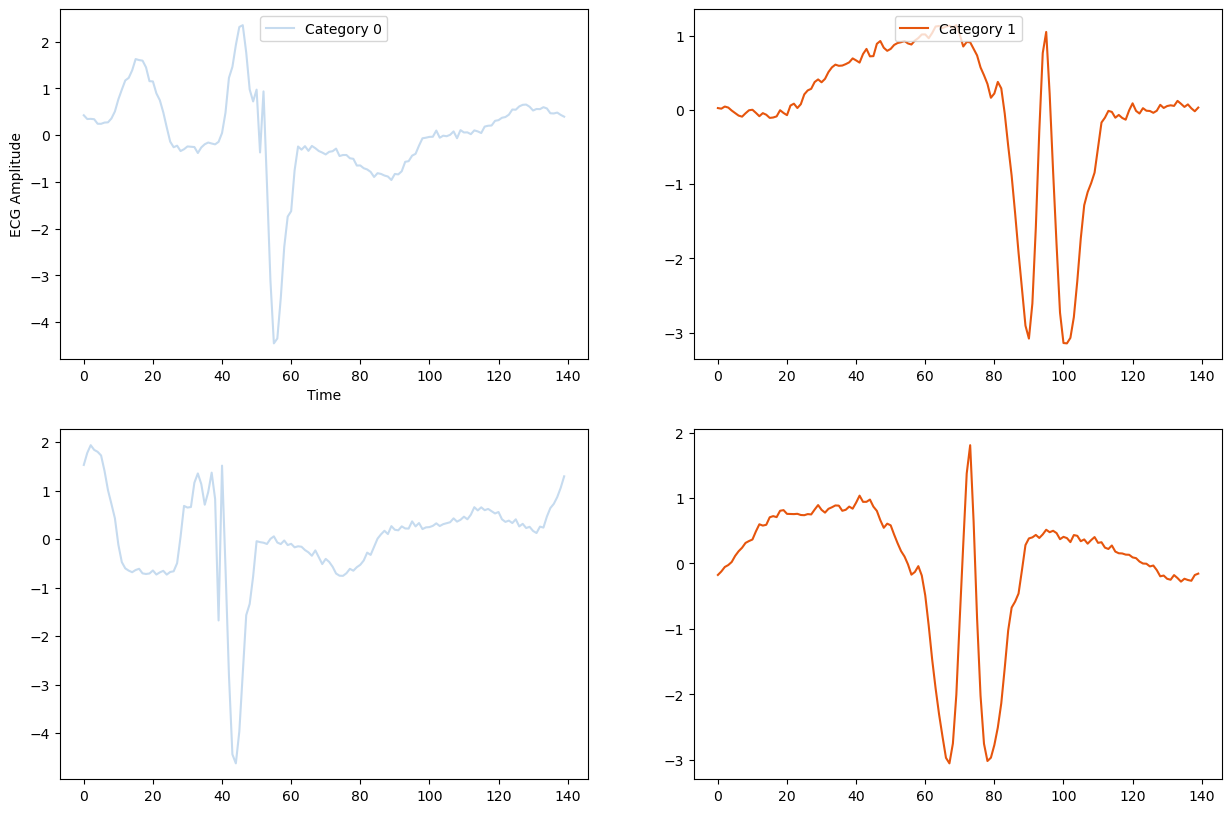

In [49]:
# visualizing data 
from matplotlib.cm import get_cmap
name = 'tab20c'
cmap = get_cmap(name)
colors_list = cmap.colors

fix, axs = plt.subplots(2, 2, figsize=(15,10))
for i in range(2):
    for j in range(2):
        idx_C = np.argwhere(np.array(y) == j)
        axs[i,j].plot(X[idx_C[i][0]], label=f'Category {j}', c=colors_list[j+3])
        if i == 0:
            axs[i,j].legend(loc='upper center')
            if j ==0:
                axs[i,j].set_xlabel('Time')
                axs[i,j].set_ylabel('ECG Amplitude')

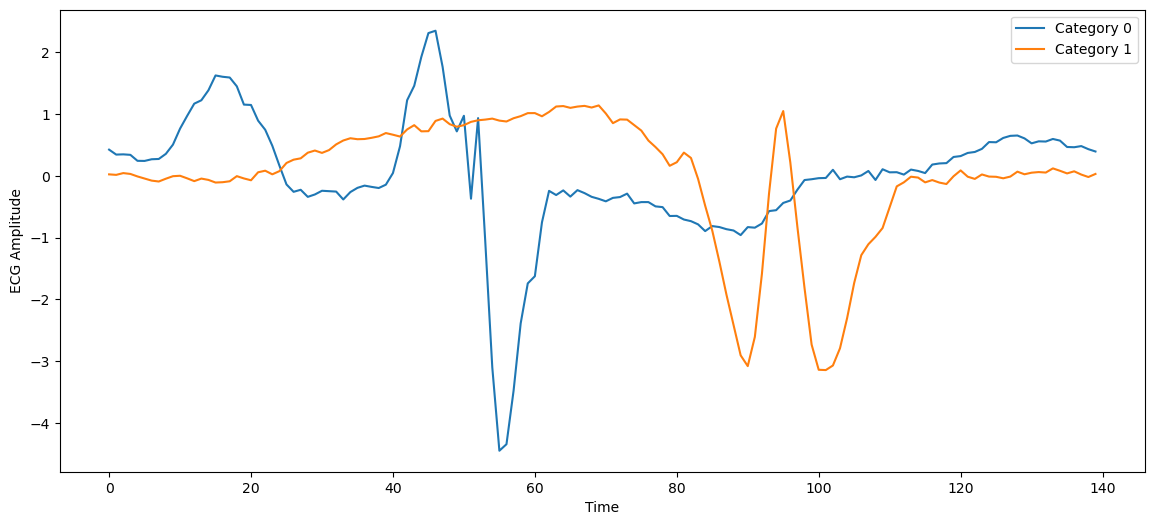

In [50]:
#stacked visualization 
plt.figure(figsize=(14, 6))
for i in range(2):
    idx_C = np.argwhere(np.array(y) == i)
    plt.plot(X[idx_C[0][0]], label=f'Category {i}')
    
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('ECG Amplitude')
plt.show()

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_pad = pad_sequences(X, dtype='float32', padding='post', value=-1)
print(X_pad.shape)
print(X_pad[0][0])

(1622, 140)
0.024133


In [52]:
#reshaping X 
X_pad= np.expand_dims(X_pad, axis=-1)

In [53]:
#classes imbalance
np.unique(y, return_counts=True)

(array([0, 1]), array([919, 703], dtype=int64))

In [54]:
# to categorical 
y_cat = to_categorical(y)
y_cat.shape

(1622, 2)

In [55]:
np.unique(y_cat, return_counts=True)

(array([0., 1.], dtype=float32), array([1622, 1622], dtype=int64))

In [56]:
#Splitting data 
X_train, X_test, y_train, y_test= train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

In [14]:
#baseline model 
sum_ = np.sum(y_train, axis=0)
predicted_category = np.argmax(sum_)

good_prediction = np.sum(y_test, axis=0)[predicted_category]
baseline_result = good_prediction/len(y_test)

print(f'Baseline accuracy: {baseline_result}')

Baseline accuracy: 0.5692307692307692


In [15]:
model = Sequential()
model.add(layers.Masking(mask_value=-1., input_shape=(140,1)))
model.add(layers.GRU(units=20, activation="tanh", input_shape=(140,1)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 140, 1)            0         
_________________________________________________________________
gru (GRU)                    (None, 20)                1380      
_________________________________________________________________
dense (Dense)                (None, 50)                1050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________


In [16]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
#compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#fit model
model.fit(X_train, y_train,
          epochs=100,
          batch_size=128,
          verbose=1,
          callbacks = [es],
          validation_split=0.2)
#evaluate model
model.evaluate(X_test, y_test)

Epoch 1/100
9/9 [==============================] - 9s 282ms/step - loss: 0.6880 - accuracy: 0.5545 - val_loss: 0.6823 - val_accuracy: 0.6115
Epoch 2/100
9/9 [==============================] - 1s 19ms/step - loss: 0.6834 - accuracy: 0.5554 - val_loss: 0.6751 - val_accuracy: 0.6115
Epoch 3/100
9/9 [==============================] - 1s 62ms/step - loss: 0.6822 - accuracy: 0.5661 - val_loss: 0.6746 - val_accuracy: 0.6115
Epoch 4/100
9/9 [==============================] - 1s 66ms/step - loss: 0.6807 - accuracy: 0.5689 - val_loss: 0.6701 - val_accuracy: 0.6115
Epoch 5/100
9/9 [==============================] - 1s 37ms/step - loss: 0.6776 - accuracy: 0.5477 - val_loss: 0.6691 - val_accuracy: 0.6115
Epoch 6/100
9/9 [==============================] - 1s 63ms/step - loss: 0.6779 - accuracy: 0.5622 - val_loss: 0.6656 - val_accuracy: 0.6115
Epoch 7/100
9/9 [==============================] - 0s 61ms/step - loss: 0.6771 - accuracy: 0.5526 - val_loss: 0.6663 - val_accuracy: 0.6115
Epoch 8/100
9/9 [==

[0.6418614387512207, 0.5907692313194275]

In [17]:
testLoss, testAcc = model.evaluate(X_test, y_test)
print('Test accuracy:', testAcc)
print('Test loss:', testLoss)

11/11 [==============================] - 0s 9ms/step - loss: 0.6419 - accuracy: 0.5908
Test accuracy: 0.5907692313194275
Test loss: 0.6418614387512207


In [18]:
#predict 
y_pred = model.predict(X_test)

In [19]:
#predicted classes
pd.DataFrame(y_pred).mean().sort_values()

1    0.442444
0    0.557556
dtype: float32

In [20]:
#actual classes count 
pd.value_counts(y,normalize=True, ascending=True)

1    0.433416
0    0.566584
dtype: float64

In [27]:
# confusion matrix
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
confusion_matrix(y_true_classes, y_pred_classes)

array([[183,   2],
       [ 11, 129]], dtype=int64)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       185
           1       0.98      0.92      0.95       140

    accuracy                           0.96       325
   macro avg       0.96      0.96      0.96       325
weighted avg       0.96      0.96      0.96       325

AUC: 0.955


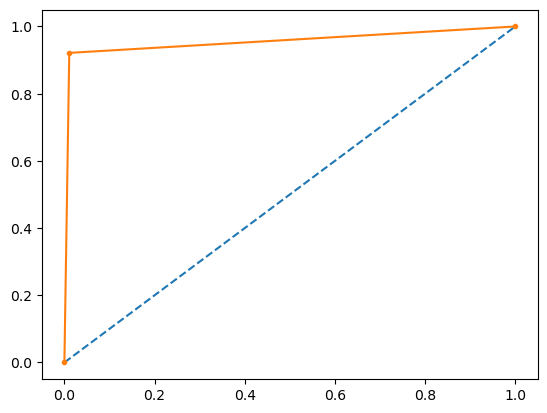

In [35]:
# Precision, Recall, F1-score, accuracy, and AUC
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes))

# AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# calculate AUC
auc = roc_auc_score(y_true_classes, y_pred_classes)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred_classes)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [29]:
# plot RNN model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
# Using LSTM
model = Sequential()
model.add(layers.Masking(mask_value=-1., input_shape=(140,1)))
model.add(layers.LSTM(units=20, activation="tanh", input_shape=(140,1)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 140, 1)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 2,912
Trainable params: 2,912
Non-trainable params: 0
_________________________________________________________________


In [22]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
#compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#fit model
model.fit(X_train, y_train,
          epochs=100,
          batch_size=128,
          verbose=1,
          callbacks = [es],
          validation_split=0.2)
#evaluate model
model.evaluate(X_test, y_test)

Epoch 1/100
9/9 [==============================] - 8s 276ms/step - loss: 0.6867 - accuracy: 0.5468 - val_loss: 0.6764 - val_accuracy: 0.6077
Epoch 2/100
9/9 [==============================] - 1s 26ms/step - loss: 0.6775 - accuracy: 0.5564 - val_loss: 0.6739 - val_accuracy: 0.6654
Epoch 3/100
9/9 [==============================] - 1s 91ms/step - loss: 0.6770 - accuracy: 0.5738 - val_loss: 0.6699 - val_accuracy: 0.6115
Epoch 4/100
9/9 [==============================] - 1s 84ms/step - loss: 0.6705 - accuracy: 0.5921 - val_loss: 0.6619 - val_accuracy: 0.6308
Epoch 5/100
9/9 [==============================] - 1s 67ms/step - loss: 0.6669 - accuracy: 0.5699 - val_loss: 0.6586 - val_accuracy: 0.6538
Epoch 6/100
9/9 [==============================] - 1s 61ms/step - loss: 0.6636 - accuracy: 0.5815 - val_loss: 0.6522 - val_accuracy: 0.6346
Epoch 7/100
9/9 [==============================] - 0s 60ms/step - loss: 0.6554 - accuracy: 0.6046 - val_loss: 0.6420 - val_accuracy: 0.6500
Epoch 8/100
9/9 [==

[0.14067725837230682, 0.9599999785423279]

In [23]:
testLoss, testAcc = model.evaluate(X_test, y_test)
print('Test accuracy:', testAcc)
print('Test loss:', testLoss)

11/11 [==============================] - 0s 9ms/step - loss: 0.1407 - accuracy: 0.9600
Test accuracy: 0.9599999785423279
Test loss: 0.14067725837230682


In [26]:
#predict 
y_pred = model.predict(X_test)

#predicted classes
print(pd.DataFrame(y_pred).mean().sort_values())
print()
#actual classes count
print(pd.value_counts(y,normalize=True, ascending=True))

1    0.422169
0    0.577831
dtype: float32

1    0.433416
0    0.566584
dtype: float64


In [30]:
# confusion matrix
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

confusion_matrix(y_true_classes, y_pred_classes)

array([[183,   2],
       [ 11, 129]], dtype=int64)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       185
           1       0.98      0.92      0.95       140

    accuracy                           0.96       325
   macro avg       0.96      0.96      0.96       325
weighted avg       0.96      0.96      0.96       325

AUC: 0.955


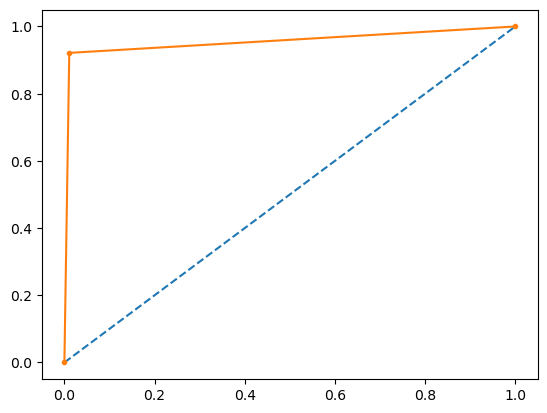

In [34]:
# Precision, Recall, F1-score, accuracy, and AUC
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes))

# AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# calculate AUC
auc = roc_auc_score(y_true_classes, y_pred_classes)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred_classes)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [31]:
# plot RNN model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


From both models (LSMT and GRU):
- The accuracy of the model on the test set is higher in the LSTM model than in the GRU model.
- The loss of the model on the test set is lower in the LSTM model than in the GRU model.

Accuracy: 0.50
SVM loss: 17.22


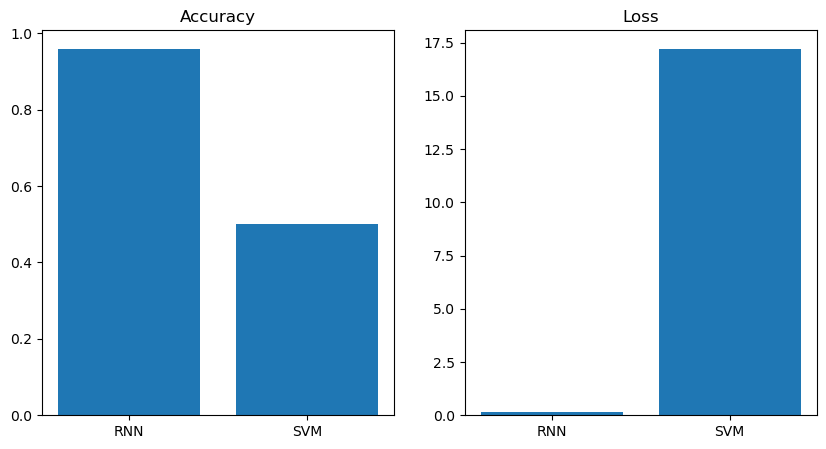

In [63]:
# Comparing the RNN with SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X = df.iloc[:, 1:]
# convert X to numpy array
# X = X.to_numpy().tolist()
# X[0][0]

y = df.iloc[:, 0]
# y = y.to_numpy().tolist()
# y[0]

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# calculate loss in SVM
from sklearn.metrics import log_loss
svm_loss = log_loss(y_test, y_pred)
print('SVM loss: %.2f' % svm_loss)

# plotting accuracy and loss between RNN and SVM
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(['RNN','SVM'],[testAcc,accuracy_score(y_test, y_pred)])
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.bar(['RNN','SVM'],[testLoss,svm_loss])
plt.title('Loss')
plt.show()

From the above graphs, we can see that the RNN is better than the SVM. The RNN has a higher accuracy and lower loss than the SVM. The RNN is also faster than the SVM.